In [4]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union

ee.Initialize()

In [6]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied, currently works for 2000 - 2018
3) Scale (optional): Resolution at which to perform analysis (if not specified, calculated automatically in EE)
4) Satellites / datasets: Queried from Earth Engine, defined in data[sat1...] 
'''

##### AREA #####

# CV
cv = gp.read_file("../shape/cv.shp")
cv_km3 = round(cv.area[0] * 10, 2)

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####

In [7]:
data = {}

###################
##### ET data #####
###################

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['terra'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*24 ]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['cas'] = [ee.ImageCollection('CAS/IGSNRR/PML/V2'), "ET_water", 1]

###################
##### P data ######
###################

data['trmm']  =  [ee.ImageCollection('TRMM/3B43V7'), "precipitation", 720]
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1]
data['chirps'] = [ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'), "precipitation", 1]
data['persia'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3
data['dmet'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V3'), "prcp", 1]

####################
##### DS data ######
####################
data['grace'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl", 1]

####################
##### R data #######
####################
data['r'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "ro", 1]
data['runoff'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "Qs_tavg", 86400*24]

#####################
##### SM data #######
#####################
data['sm'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "soil", 0.1]

data['sm1'] = [ee.ImageCollection("INASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi00_10cm_tavg", 86400*24]
data['sm2'] = [ee.ImageCollection("INASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi10_40cm_tavg", 86400*24]
data['sm3'] = [ee.ImageCollection("INASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi40_100cm_tavg", 86400*24]
data['sm4'] = [ee.ImageCollection("INASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi100_200cm_tavg", 86400*24]

In [8]:
def get_data(dataset, year, month):

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale().getInfo()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var] # * 1e-9 # convert m^3 to km^3
    
    return result

def wrapper(dataset):
    monthly = []

    for year in years:
        for month in months:
            r = get_data(dataset, year, month)
            monthly.append(r)
    
    print("wrapper complete")
    return monthly

In [9]:
years = range(2001, 2018)
months = range(1,13)

start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [10]:
# This will take a very long time to run
et_m = wrapper(data['modis'])
eto_g = wrapper(data['gmet_eto'])
etr_g = wrapper(data['gmet_etr'])
et_f = wrapper(data['fldas'])
et_t = wrapper(data['terra'])


wrapper complete
wrapper complete
wrapper complete
wrapper complete
wrapper complete


In [11]:
# This will take less long, but still a long time
p_p = wrapper(data['prism'])
p_c = wrapper(data['chirps'])
p_n = wrapper(data['persia'])
p_t = wrapper(data['trmm'])
p_d = wrapper(data['dmet'])


wrapper complete
wrapper complete
wrapper complete
wrapper complete
wrapper complete


In [12]:
# Fetch Soil Moisture and runoff
sm = wrapper(data['sm'])
r = wrapper(data['r'])

wrapper complete
wrapper complete


In [64]:
# Stack datasets 
p_arrs = [np.array(x) for x in [p_p, p_c, p_n, p_t]]
p_stacked = np.column_stack(p_arrs)
p = np.mean(p_stacked, axis = 1)

et_arrs = [np.array(x) for x in [et_m, eto_g, etr_g, et_f, et_t]]
et_stacked = np.column_stack(et_arrs)
et = np.mean(et_stacked, axis = 1)

No handles with labels found to put in legend.


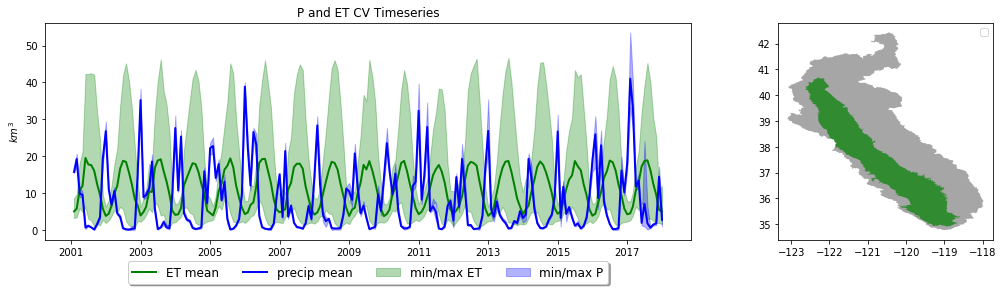

In [65]:
# Plot the means and ranges

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(17,4))

a0.set_title("P and ET CV Timeseries")

a0.plot(dt_idx, et, label = "ET mean", color = "green", linewidth=2.0)
a0.fill_between(dt_idx, np.min(et_stacked, axis = 1), np.max(et_stacked, axis = 1), alpha = 0.3, color = "green", label = "min/max ET")

a0.plot(dt_idx, p, label = "precip mean", color = "blue", linewidth = 2.0)
a0.fill_between(dt_idx, np.min(p_stacked, axis = 1), np.max(p_stacked, axis = 1), alpha = 0.3, color = "blue", label = "min/max P")
a0.set_ylabel("$km^3$")
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

ssjt.plot(ax=a1, color = "gray", alpha = 0.7, label = "SSJT area = {} $km^2$".format(round(sa_km3, 3)))
cv.plot(ax=a1, color = "green", alpha = 0.7, label =  "CV area = {} $km^2$".format(round(cv_km3, 3)))
a1.legend()

plt.show()

In [66]:
# Read c2vsim storage data

data_dir = "../data/"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".txt")]
ds = pd.read_csv(files[0], sep='\t', header=0)
ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

# remove local timezone
ds = ds.tz_localize(None).copy()
ds.drop(["dt", "region"],axis = 1, inplace = True)
ds['s'] = ds['s'] * 1.23348 # MAF to km^3

# Read USGS Reservoir data
res_s = pd.read_csv("../data/reservoir_storage_ssjt.csv")
res_s.set_index(res_s.columns[0], inplace = True)
res_s.index = pd.to_datetime(res_s.index)
res_s.index.name = "date"

# Read Q Out data from Dayflow: 
q_out1 = pd.read_csv("../data/Qs_out_dayflow.csv")
q_out1.set_index(q_out1.columns[0], inplace = True)
q_out1.index = pd.to_datetime(q_out1.index)
q_out1.index.name = "date"

# Read Q Out data from CA Aqueduct: 
q_out2 = pd.read_csv("../data/Qs_out_ca_aqeduct.csv")
q_out2.set_index(q_out2.columns[0], inplace = True)
q_out2.index = pd.to_datetime(q_out2.index)
q_out2.index.name = "date"

In [67]:
# Make a df from precip and ET RS data:

years = [x for x in range(2001, 2018)]
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

petdf = pd.DataFrame([r, sm, p_p, p_c, p_n, p_t,p_d, et_m, eto_g, etr_g, et_f, et_t, list(p),list(et)]).T
petdf.index = dt_idx

In [89]:
df_t1 = pd.merge(petdf,q_out1, how='inner', left_index=True, right_index=True)
df_t2 = pd.merge(df_t1,q_out2, how='inner', left_index=True, right_index=True)
df2_temp = pd.merge(df_t2,res_s, how='inner', left_index=True, right_index=True)
df = pd.merge(df2_temp,ds, how='inner', left_index=True, right_index=True)

df.columns = ["runoff", "soil_moisture", "prism", "chirps", 
              "persiann" ,"trmm", "daymet", "modis", "gmet_eto", 
              "gmet_etr", "fldas", "terraclimate", 'p_mean', 'et_mean', 
              "q_out1","q_out2","res_s", "c2v_s"]

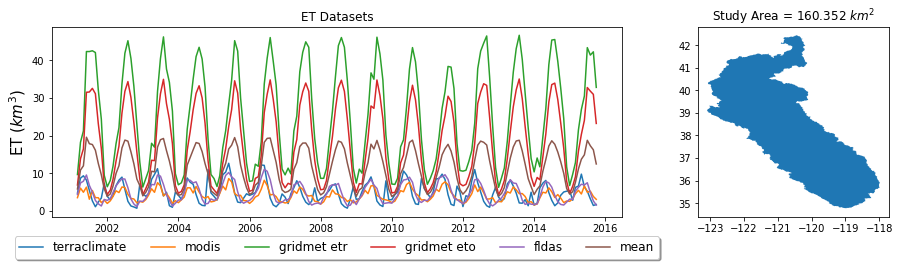

In [90]:
# Plot the ET Datasets

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("ET Datasets")
a0.plot(df.index, df.terraclimate, label = 'terraclimate')
a0.plot(df.index, df.modis, label = "modis")
a0.plot(df.index, df.gmet_etr, label = 'gridmet etr')
a0.plot(df.index, df.gmet_eto, label = 'gridmet eto')
a0.plot(df.index, df.fldas, label = 'fldas')
a0.plot(df.index, df.et_mean, label = 'mean')
a0.set_ylabel('ET $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
ssjt.plot(ax=a1)

plt.show()

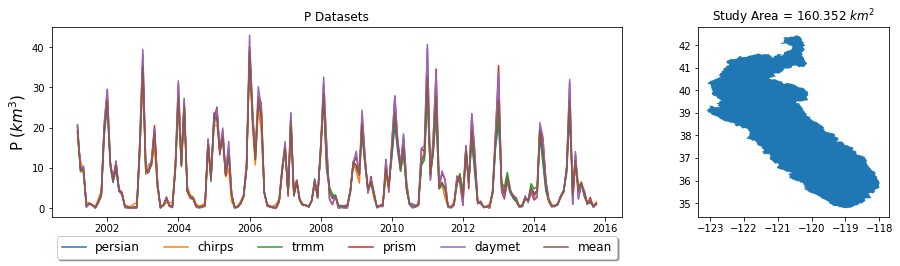

In [91]:
# P datasets

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("P Datasets")

a0.plot(df.index, df.persiann, label = 'persian')
a0.plot(df.index, df.chirps, label = "chirps")
a0.plot(df.index, df.trmm, label = 'trmm')
a0.plot(df.index, df.prism, label = 'prism')
a0.plot(df.index, df.daymet, label = 'daymet')
a0.plot(df.index, df.p_mean, label = 'mean')
a0.set_ylabel('P $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
ssjt.plot(ax=a1)

plt.show()

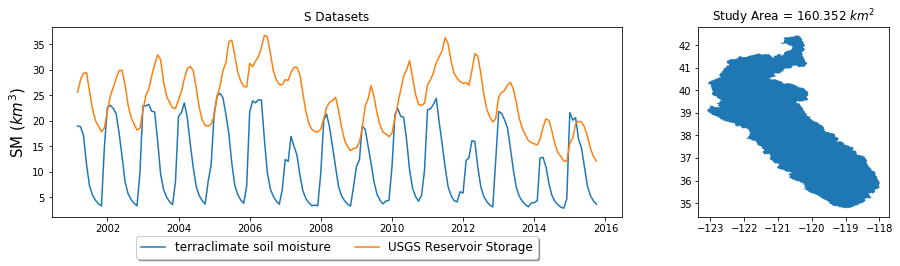

In [92]:
# SM data

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("S Datasets")

a0.plot(df.index, df.soil_moisture, label = 'terraclimate soil moisture')
a0.plot(df.index, df.res_s, label = 'USGS Reservoir Storage')

a0.set_ylabel('SM $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
ssjt.plot(ax=a1)

plt.show()

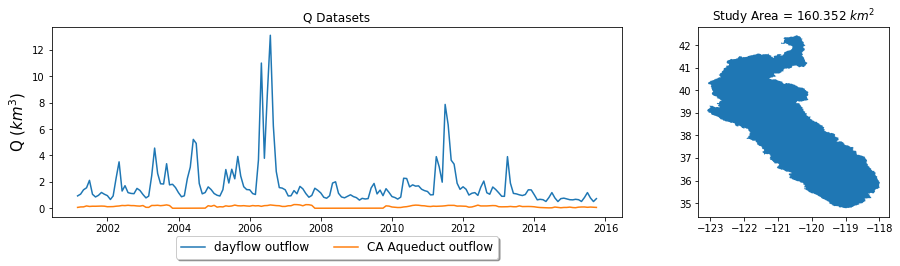

In [93]:
# Q data

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("Q Datasets")

a0.plot(df.index, df.q_out1, label = 'dayflow outflow')
a0.plot(df.index, df.q_out2, label = 'CA Aqueduct outflow')

a0.set_ylabel('Q $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
ssjt.plot(ax=a1)

plt.show()

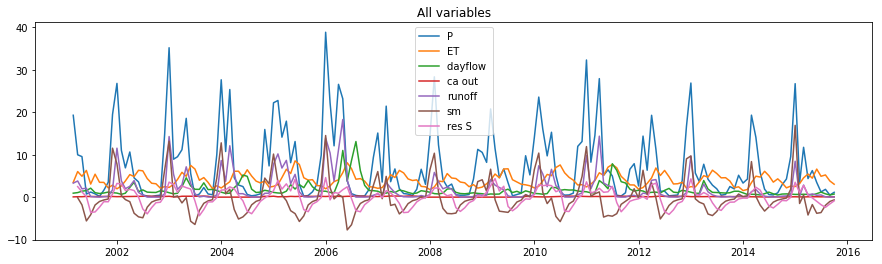

In [94]:
plt.figure(figsize=(15,4))
plt.title("All variables")
plt.plot(df.p_mean, label = "P")
plt.plot(df.modis, label = "ET")
plt.plot(df.q_out1, label = "dayflow ")
plt.plot(df.q_out2, label = "ca out")
plt.plot(df.runoff, label = "runoff")
plt.plot(df.soil_moisture.diff(), label= "sm")
plt.plot(df.res_s.diff(), label= "res S")
plt.legend()

In [138]:
# save the csv
# df.to_csv("../data/all_data_ssjt.csv")

df['ds'] = (df.p_mean - df.et_mean - df.q_out1 - df.q_out2  - df.soil_moisture.diff() - df.res_s.diff())
df.ds[0] = df.c2v_s.iloc[0]

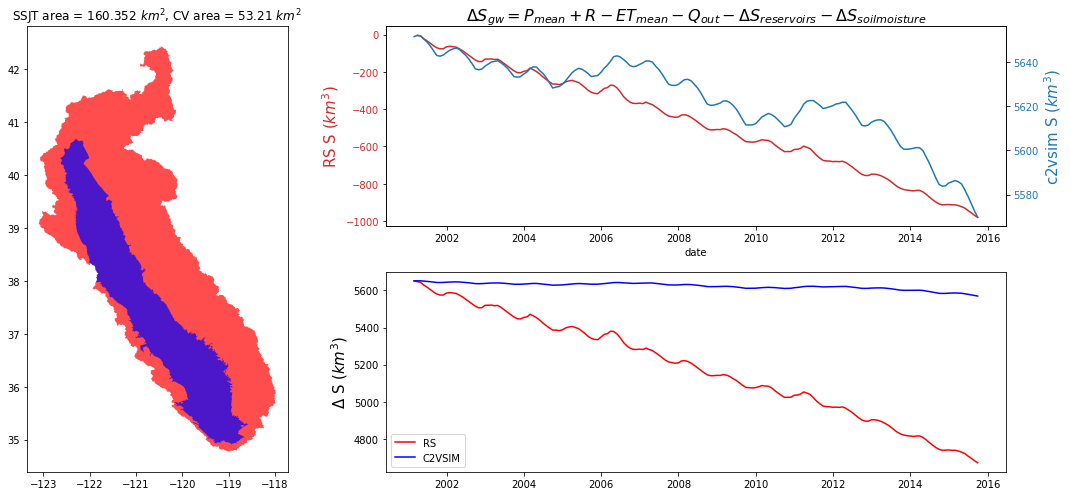

In [139]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_2 = plt.subplot(G[0, 1:])

color = 'tab:red'
axes_2.set_title("$\Delta S_{gw} = P_{mean} + R -  ET_{mean} - Q_{out} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)

axes_2.set_xlabel('date')
axes_2.set_ylabel('RS S $(km^3)$', color=color, size = 15)
axes_2.plot(df.index[1:], np.cumsum(df.ds[1:]), color=color)
axes_2.tick_params(axis='y', labelcolor=color)

axes_3 = axes_2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
axes_3.set_ylabel('c2vsim S ($km^3$)', color=color, size = 15) 
axes_3.set_xlabel('date')
axes_3.plot(df.index, df.c2v_s, color=color)
axes_3.tick_params(axis='y', labelcolor=color)

axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS")
axes_4.plot(df.index, df.c2v_s, color="blue", label = "C2VSIM")
axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.tight_layout()
plt.show()

# Annual Sums

In [140]:
# Compute annual (hydrologic year) ds sums from ds:
years = np.arange(df.index[0].year, df.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 10

for year in years:

    # Select df for nov and the first year
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['c2v_s'][-1] - hydro_year_df['c2v_s'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()
    

In [141]:
dt_y = pd.date_range(start=df.index[0], end=df.index[-2] + relativedelta(years=-1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})
ds_df.index = dt_y

# Scaling: 
## $ X_{scaled} = \frac{X_i - \mu}{\sigma_x}$

In [142]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


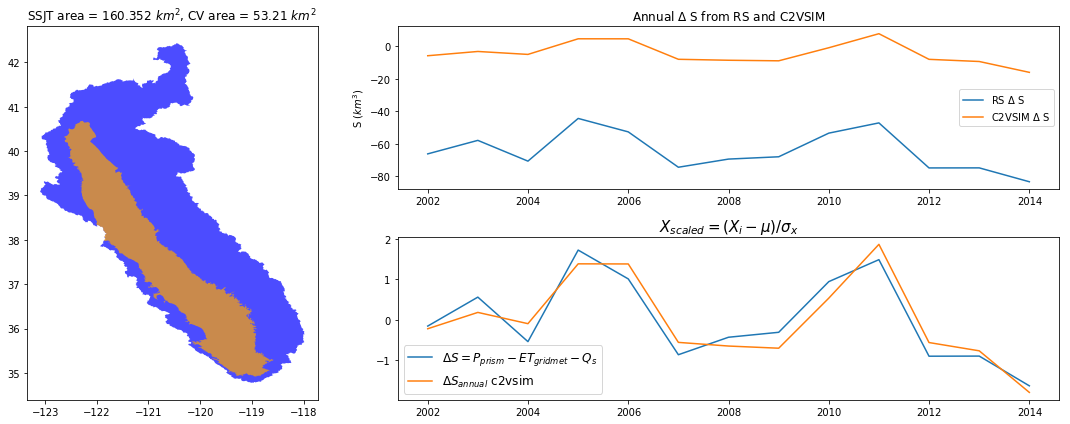

In [143]:
# Plot

plt.figure(figsize=(15, 6))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "blue", alpha = 0.7)
cv.plot(ax=axes_1, color = "orange", alpha = 0.7)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_2 = plt.subplot(G[0, 1:])
axes_2.set_title("Annual $\Delta$ S from RS and C2VSIM")
axes_2.plot(ds_df.index,ds_df.ds, label = "RS $\Delta$ S")
axes_2.plot(ds_df.index,ds_df.c2vds, label = "C2VSIM $\Delta$ S")
axes_2.set_ylabel("S $(km^3)$")
axes_2.legend()

axes_3 = plt.subplot(G[1, 1:])
axes_3.set_title("$ X_{scaled} = ({X_i - \mu})/{\sigma_x}$", size = 15)
axes_3.plot(ds_df.index, scaled[0], label = "$\Delta S = P_{prism} - ET_{gridmet} - Q_{s}$")
axes_3.plot(ds_df.index, scaled[1], label = "$\Delta S_{annual}$ c2vsim")
axes_3.legend(loc="lower left", fontsize = 'large')

plt.tight_layout()
plt.show()

In [3]:
whos

Interactive namespace is empty.
